## FB15k-237 semantic graph

https://www.kaggle.com/datasets/latebloomer/fb15k-237/data

https://www.kaggle.com/datasets/latebloomer/freebase-wikidata-mapping

In [101]:
# !pip install kagglehub

In [102]:
# import kagglehub

# path = kagglehub.dataset_download("latebloomer/fb15k-237")
# print("Path to dataset files:", path)

In [103]:
import pandas as pd
import numpy as np

In [104]:
data_path = "../datasets/fb15k-237/"

### Load triples and augment from source

### Load augmented triples directly

In [105]:
relations_df = pd.read_csv(f"{data_path}/derived/relations_with_ids.csv")

In [106]:
relations_df.head()

,relation_name,relation_id
0,/location/country/form_of_government,0
1,/tv/tv_program/regular_cast./tv/regular_tv_app...,1
2,/media_common/netflix_genre/titles,2
3,/award/award_winner/awards_won./award/award_ho...,3
4,/soccer/football_team/current_roster./sports/s...,4


In [107]:
freebase_vs_wiki_df =  pd.read_csv(f"{data_path}/derived/fb_wiki_mapping_incl_wiki_extracts.csv")
# strip Q from wikidata id for easier use with Kumo AI
freebase_vs_wiki_df['wikidata_int_id'] = freebase_vs_wiki_df.apply(lambda row: int(row['wikidata_id'][1:]), axis=1)
freebase_vs_wiki_df.drop('wikidata_id', axis=1, inplace=True)
freebase_vs_wiki_df.rename(columns={'wikidata_int_id':'wikidata_id'}, inplace=True)
freebase_vs_wiki_df_mini = freebase_vs_wiki_df[['wikidata_id', 'Title', 'Extract']]
freebase_vs_wiki_df.head(3)

,freebase_id,label,Title,Extract,wikidata_id
0,/m/010016,Denton,"Denton, Texas",Denton is a city in the U.S. state of Texas an...,128306
1,/m/0100mt,El Paso,"El Paso, Texas",El Paso is a city in and the county seat of El...,16562
2,/m/0102t4,Marshall,"Marshall, Texas",Marshall is a city in the U.S. state of Texas....,52996


In [108]:
def denormalize(triplets):
    triplets['disapprove'] = triplets['disapprove'].astype('bool')
    triplets = pd.merge(triplets, freebase_vs_wiki_df_mini, how='left',left_on='src_wikidata_id', right_on='wikidata_id')
    triplets.rename(columns={'Title':'src_title'}, inplace=True)
    triplets.rename(columns={'Extract':'src_extract'}, inplace=True)

    triplets = pd.merge(triplets, freebase_vs_wiki_df_mini, how='left',left_on='dest_wikidata_id', right_on='wikidata_id')
    triplets.rename(columns={'Title':'dest_title'}, inplace=True)
    triplets.rename(columns={'Extract':'dest_extract'}, inplace=True)

    triplets['src_title'] = triplets['src_title'].astype('string')
    triplets['src_extract'] = triplets['src_extract'].astype('string')
    triplets['dest_title'] = triplets['dest_title'].astype('string')
    triplets['dest_extract'] = triplets['dest_extract'].astype('string')
    triplets.reset_index(inplace=True)
    return triplets

triplets = (pd.read_csv(f"{data_path}/exp3/triplets_with_src_dst_wiki_ids.csv"))
triplets = denormalize(triplets)
triplets.head()

,index,src_freebase_id,relation,dest_freebase_id,triple_id,timestamp,relation_name,relation_id,freebase_id_x,label_x,...,freebase_id_y,label_y,dest_wikidata_id,disapprove,wikidata_id_x,src_title,src_extract,wikidata_id_y,dest_title,dest_extract
0,0,/m/027rn,/location/country/form_of_government,/m/06cx9,0,2024-10-06,/location/country/form_of_government,0,/m/027rn,Dominican Republic,...,/m/06cx9,republic,7270,False,786.0,Dominican Republic,The Dominican Republic is a country in the Car...,7270.0,Republic,"A republic, based on the Latin phrase res publ..."
1,1,/m/07s9rl0,/media_common/netflix_genre/titles,/m/0170z3,2,2024-12-08,/media_common/netflix_genre/titles,2,/m/07s9rl0,drama film,...,/m/0170z3,American History X,208572,False,130232.0,Drama (film and television),"In film and television, drama is a category or...",208572.0,American History X,American History X is a 1998 American crime dr...
2,2,/m/0cnk2q,/soccer/football_team/current_roster./sports/s...,/m/02nzb8,4,2024-11-26,/soccer/football_team/current_roster./sports/s...,4,/m/0cnk2q,Australia men's national soccer team,...,/m/02nzb8,midfielder,193592,False,268208.0,Australia men's national soccer team,The Australia men's national soccer team repre...,193592.0,Midfielder,"In association football, a midfielder takes an..."
3,3,/m/0q9kd,/award/award_nominee/award_nominations./award/...,/m/0184jc,8,2024-10-13,/award/award_nominee/award_nominations./award/...,8,/m/0q9kd,Danny DeVito,...,/m/0184jc,Guy Pearce,223745,False,26806.0,Danny DeVito,"Daniel Michael DeVito Jr. (born November 17, 1...",223745.0,Guy Pearce,Guy Edward Pearce (born 5 October 1967) is an ...
4,4,/m/0b76d_m,/film/film/release_date_s./film/film_regional_...,/m/029j_,11,2024-12-06,/film/film/release_date_s./film/film_regional_...,11,/m/0b76d_m,Anonymous,...,/m/029j_,DVD,5294,False,313819.0,Anonymous (film),Anonymous is a 2011 period drama film directed...,5294.0,DVD,The DVD (common abbreviation for digital video...


In [109]:
triplets_test = pd.read_csv(f"{data_path}/exp3/triplets_with_src_dst_wiki_ids.test.csv")
triplets_test = denormalize(triplets_test)
triplets_test.head()

,index,src_freebase_id,relation,dest_freebase_id,timestamp,relation_name,relation_id,freebase_id_x,label_x,src_wikidata_id,...,label_y,dest_wikidata_id,triple_id,disapprove,wikidata_id_x,src_title,src_extract,wikidata_id_y,dest_title,dest_extract
0,0,/m/02jx1,/location/location/contains,/m/013t85,2025-01-02,/location/location/contains,15,/m/02jx1,England,21,...,Pontefract,1009235,272118,False,21.0,England,England is a country that is part of the Unite...,1009235.0,Pontefract,Pontefract is a historic market town in the Ci...
1,1,/m/05zrvfd,/award/award_category/nominees./award/award_no...,/m/04y9mm8,2025-01-02,/award/award_category/nominees./award/award_no...,7,/m/05zrvfd,MTV Movie Award for Best Scared-As-S**t Perfor...,425675,...,Piranha 3D,733995,272121,False,425675.0,MTV Movie Award for Best Scared-As-Shit Perfor...,The following is a list for the MTV Movie & TV...,733995.0,Piranha 3D,Piranha 3D is a 2010 American 3D horror comedy...
2,2,/m/07l450,/film/film/genre,/m/082gq,2025-01-02,/film/film/genre,31,/m/07l450,The Last King of Scotland,176826,...,war film,369747,272123,False,176826.0,The Last King of Scotland (film),The Last King of Scotland is a 2006 historical...,369747.0,War film,War film is a film genre concerned with warfar...
3,3,/m/07h1h5,/sports/pro_athlete/teams./sports/sports_team_...,/m/029q3k,2025-01-02,/sports/pro_athlete/teams./sports/sports_team_...,40,/m/07h1h5,Kasper Schmeichel,295797,...,Notts County F.C.,19598,272124,False,295797.0,Kasper Schmeichel,Kasper Peter Schmeichel (born 5 November 1986)...,19598.0,Notts County F.C.,Notts County Football Club is a professional f...
4,4,/m/0kbws,/olympics/olympic_games/participating_countries,/m/027jk,2025-01-02,/olympics/olympic_games/participating_countries,157,/m/0kbws,2008 Summer Olympics,8567,...,Djibouti,977,272133,False,8567.0,2008 Summer Olympics,The 2008 Summer Olympics (Chinese: 2008年夏季奥运会)...,977.0,Djibouti,"Djibouti, officially the Republic of Djibouti,..."


In [110]:
combined_triplets = pd.concat([triplets, triplets_test])
# combined_triplets['disapprove'] = combined_triplets['disapprove'].astype('float')
combined_triplets[['disapprove']].value_counts()
combined_triplets['timestamp'] = pd.to_datetime(combined_triplets['timestamp'])

In [111]:
data_quality_df = combined_triplets[['triple_id', 'disapprove']].copy()
data_quality_df['id'] = data_quality_df.index
data_quality_df['disapprove'] = data_quality_df['disapprove'].astype('int')

# add random timestamps to force fit into KumoAI restrictions
base_date = pd.Timestamp('2025-02-01')
num_triples = len(data_quality_df)
random_days_ago_integers = np.random.randint(1, 24, size=num_triples)
time_deltas = pd.to_timedelta(random_days_ago_integers, unit='days')
data_quality_df['created_at'] = base_date - time_deltas
data_quality_df.head()

,triple_id,disapprove,id,created_at
0,0,0,0,2025-01-28
1,2,0,1,2025-01-26
2,4,0,2,2025-01-22
3,8,0,3,2025-01-23
4,11,0,4,2025-01-09


In [112]:
import kumoai as kumo
import kumoai.experimental.rfm as rfm
import os
if not os.environ.get("KUMO_API_KEY"):
    rfm.authenticate()
KUMO_API_KEY = os.environ.get("KUMO_API_KEY")
rfm.init(api_key=KUMO_API_KEY)

Client has already been created. To re-initialize Kumo, please start a new interpreter. No changes will be made to the current session.


In [113]:
#combined_triplets.reset_index(inplace=True)
triples = rfm.LocalTable(
    combined_triplets[['triple_id', 'src_wikidata_id', 'relation_id', 'dest_wikidata_id', 'timestamp', 'src_title', 'src_extract', 'dest_title', 'dest_extract']],
    name="triples"
).infer_metadata()

#relations_df.reset_index(inplace=True)
relations = rfm.LocalTable(
    relations_df, name="relations", primary_key='relation_id'
).infer_metadata()

data_quality_df.reset_index(inplace=True)
data_quality = rfm.LocalTable(
    data_quality_df, name="data_quality"
).infer_metadata()
data_quality.column("disapprove").stype = "numerical"

freebase_vs_wiki_df.reset_index(inplace=True)
freebase_vs_wiki1 = rfm.LocalTable(
    freebase_vs_wiki_df,
    name="freebase_vs_wiki_src",
    primary_key="wikidata_id"
).infer_metadata()

freebase_vs_wiki_df.reset_index(inplace=True)
freebase_vs_wiki2 = rfm.LocalTable(
    freebase_vs_wiki_df.copy(),
    name="freebase_vs_wiki_dest",
    primary_key="wikidata_id"
).infer_metadata()

Detected primary key 'triple_id' and time column 'timestamp' in table 'triples'
Detected primary key 'id' and time column 'created_at' in table 'data_quality'


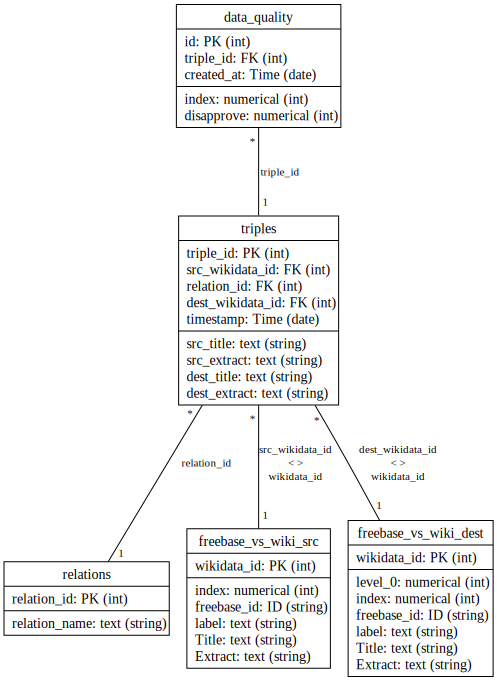

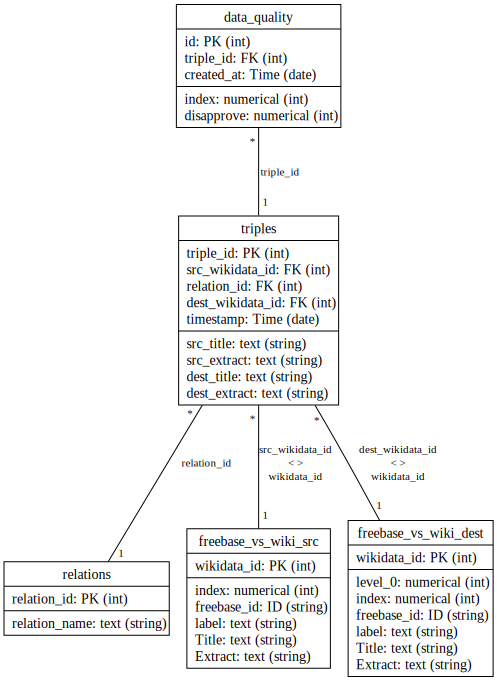

In [114]:
graph = rfm.LocalGraph(tables=[
    triples,
    relations,
    freebase_vs_wiki1,
    freebase_vs_wiki2,
    data_quality,
])
# graph.link(src_table="freebase_vs_wiki", fkey="src_wikidata_id", dst_table="triples")
graph.link(src_table="triples", fkey="src_wikidata_id", dst_table="freebase_vs_wiki_src")
graph.link(src_table="data_quality", fkey="triple_id", dst_table="triples")
graph.link(src_table="triples",fkey="relation_id", dst_table="relations")
graph.link(src_table="triples", fkey="dest_wikidata_id", dst_table="freebase_vs_wiki_dest")
graph.visualize()

In [115]:
# graph['triples']['relation'].stype
# graph['triples']['relation_id'].stype

In [116]:
model = rfm.KumoRFM(graph)

Output()

In [117]:
# PREDICT triples.relation
# Couldn't pick a unique triples.relation for each freebase_vs_wiki. row 1, column 8: Encountered an error, we have found 
# multiple 'relation' values in the 'triples' table for a single 'freebase_vs_wiki'. To fix this, you have two options:
## 1. Aggregate the values: If your 'triples' table has a 'created at' column, use an aggregation function to reduce them to one value. 
##   For example: PREDICT LAST(triples.relation, 0, 30, days).
## 2. Rewrite your query: If you are writing a static node prediction predictive query, make sure that you 
##   either use the same table to define your target and entity, or you have a foreign key from the entity pointing to the target table, 
##   not the other way around.

# PREDICT triples.relation RANK TOP 10
## Problem type 'ProblemType.RANK' is only supported for multicategorical targets. . row 1, column 8: Target 'triples.relation' is 
## not multicategorical. Either drop the problem type ProblemType.RANK OR 
## change the target to a multicategorical column, 'LAST'/'FIRST' aggregation of a multicategorical column, or a 'LIST_DISTINCT' aggregation.

# FOR triples.src_wikidata_id=7413907
# Invalid entity. row 2, column 4: Entity 'triples.src_wikidata_id' is not a primary key. 
# The column used in 'FOR EACH' has to be a primary key.

# FOR 

# WHERE triples.relation contains 'place'


In [118]:
# kumo.init(api_key=KUMO_API_KEY)

In [119]:
# Working queries

query = """
PREDICT freebase_vs_wiki.freebase_id 
FOR freebase_vs_wiki.wikidata_id=7413907 
"""

query = """
PREDICT LIST_DISTINCT(triples.relation_id, 0, 80, days)
FOR freebase_vs_wiki.wikidata_id=486860 
"""

# relations / types of edges for Arnold Schwarzenegger
query = """
PREDICT LIST_DISTINCT(triples.relation_id, 0, 80, days)
FOR freebase_vs_wiki_src.wikidata_id=2685 
"""

query1 = """
PREDICT triples.inaccurate
FOR triples.triple_id =2685 
"""

# FOR triples.triple_id IN (1,2,3,4,168229,155507,15727) 

"""
PREDICT LIST_DISTINCT(triples.relation_id WHERE triples.inaccurate = 1, 0, 80, days)
FOR freebase_vs_wiki_src.wikidata_id=2685  
"""


'\nPREDICT LIST_DISTINCT(triples.relation_id WHERE triples.inaccurate = 1, 0, 80, days)\nFOR freebase_vs_wiki_src.wikidata_id=2685  \n'

In [120]:
# all triples associated with 2685
triple_ids_arnie=triplets.loc[triplets['src_wikidata_id']==2685].triple_id.to_list()

In [121]:
triple_ids_arnie_str = f"{triple_ids_arnie}"
triple_ids_arnie_str = triple_ids_arnie_str.replace("[","(").replace("]",")")

In [122]:
query1 = """
PREDICT data_quality.disappove
FOR triples.triple_id IN """ + triple_ids_arnie_str

In [123]:
# triples with label 1 / inaccurate facts from test set
probe_triplet_ids_errors=triplets.loc[triplets['disapprove']==True].sample(100).triple_id.to_list()
probe_triplet_ids_non_errors=triplets.loc[triplets['disapprove']==False].sample(100).triple_id.to_list()

probe_triplet_ids_str = f"{probe_triplet_ids_errors}"
probe_triplet_ids_str = probe_triplet_ids_str.replace("[","(").replace("]",")")

In [124]:
probe_triplet_ids_str = f"{probe_triplet_ids_errors}"
probe_triplet_ids_str = probe_triplet_ids_str.replace("[","(").replace("]",")")
# print(probe_triplet_ids_str)

query1 = """
PREDICT AVG(data_quality.disapprove, 0, 80, days)
FOR triples.triple_id IN """ + probe_triplet_ids_str

pred1_df = model.predict(query1)

probe_triplet_ids_str = f"{probe_triplet_ids_non_errors}"
probe_triplet_ids_str = probe_triplet_ids_str.replace("[","(").replace("]",")")
query2 = """
PREDICT AVG(data_quality.disapprove, 0, 80, days)
FOR triples.triple_id IN """ + probe_triplet_ids_str

pred2_df = model.predict(query2)

/Users/saikrishna/Documents/GitHub/kumoai_hackathon/.venv/lib/python3.13/site-packages/kumoai/experimental/rfm/rfm.
py:360: UserWarning: Anchor timestamp is too early or aggregation time range is too large. To form proper input 
data, we would need data back to '2024-08-24 00:00:00', however, your data only contains data back to '2024-10-04 
00:00:00'.
  warnings.warn(f"Anchor timestamp is too early or aggregation "

Output()

/Users/saikrishna/Documents/GitHub/kumoai_hackathon/.venv/lib/python3.13/site-packages/kumoai/experimental/rfm/rfm.
py:360: UserWarning: Anchor timestamp is too early or aggregation time range is too large. To form proper input 
data, we would need data back to '2024-08-24 00:00:00', however, your data only contains data back to '2024-10-04 
00:00:00'.
  warnings.warn(f"Anchor timestamp is too early or aggregation "

Output()

In [125]:
print(pred1_df.TARGET_PRED.describe())

print(pred2_df.TARGET_PRED.describe())

count    100.000000
mean       0.402056
std        0.019367
min        0.365320
25%        0.388034
50%        0.402277
75%        0.415679
max        0.443488
Name: TARGET_PRED, dtype: float64
count    100.000000
mean       0.404090
std        0.020766
min        0.365468
25%        0.388119
50%        0.404669
75%        0.421635
max        0.454708
Name: TARGET_PRED, dtype: float64


In [126]:
# pred1_df.loc[pred1_df['PREDICTED']==False].sort_values(by='SCORE', ascending=False)
pred1_df.sort_values(by='TARGET_PRED', ascending=False)

,ENTITY,ANCHOR_TIMESTAMP,TARGET_PRED
71,74203,1738281600000,0.443488
87,238283,1738281600000,0.443391
60,85995,1738281600000,0.442167
24,21514,1738281600000,0.437735
33,236456,1738281600000,0.435823
...,...,...,...
16,176420,1738281600000,0.372166
92,270099,1738281600000,0.370847
14,212802,1738281600000,0.369565
91,189273,1738281600000,0.369101


In [127]:
triplets_test.loc[triplets_test['disapprove']==True].head()

,index,src_freebase_id,relation,dest_freebase_id,timestamp,relation_name,relation_id,freebase_id_x,label_x,src_wikidata_id,...,label_y,dest_wikidata_id,triple_id,disapprove,wikidata_id_x,src_title,src_extract,wikidata_id_y,dest_title,dest_extract
9144,9144,/m/0j6b5,/film/film/release_date_s./film/film_regional_...,/m/0d060g,2025-01-02,/film/film/release_date_s./film/film_regional_...,13,/m/0j6b5,Spirited Away,155653,...,United States Department of Housing and Urban ...,811595,283384,True,155653.0,Spirited Away,Spirited Away is a 2001 Japanese animated fant...,811595.0,United States Department of Housing and Urban ...,The United States Department of Housing and Ur...
9145,9145,/m/013nws,/location/hud_foreclosure_area/estimated_numbe...,/m/0jbk9,2025-01-02,/location/hud_foreclosure_area/estimated_numbe...,120,/m/013nws,Eau Claire,122563,...,Canada,16,280120,True,122563.0,"Eau Claire, Wisconsin",Eau Claire ( oh-KLAIR; French: [o klɛʁ] lit. ...,16.0,Canada,Canada is a country in North America. Its ten ...
9146,9146,/m/09b3v,/media_common/netflix_genre/titles,/m/01jrbb,2025-01-02,/media_common/netflix_genre/titles,2,/m/09b3v,The Walt Disney Company,7414,...,Czech Republic,213,275023,True,7414.0,The Walt Disney Company,"The Walt Disney Company, commonly referred to ...",213.0,Czech Republic,"The Czech Republic, also known as Czechia and ..."
9147,9147,/m/06w839_,/film/film/release_date_s./film/film_regional_...,/m/01mjq,2025-01-02,/film/film/release_date_s./film/film_regional_...,13,/m/06w839_,Ice Age,305250,...,Finding Nemo,132863,275870,True,305250.0,Ice Age (2002 film),Ice Age is a 2002 American animated adventure ...,132863.0,Finding Nemo,Finding Nemo is a 2003 American animated comed...
9148,9148,/m/0kbws,/olympics/olympic_games/participating_countries,/m/056vv,2025-01-02,/olympics/olympic_games/participating_countries,157,/m/0kbws,2008 Summer Olympics,8567,...,Arizona Cardinals,224164,289246,True,8567.0,2008 Summer Olympics,The 2008 Summer Olympics (Chinese: 2008年夏季奥运会)...,224164.0,Arizona Cardinals,The Arizona Cardinals are a professional Ameri...


pquery_relations_for_entity = kumo.PredictiveQuery(
	graph=graph,
	query=query
)

pquery_relations_for_entity.validate()

In [128]:
graph._to_api_graph_definition()

GraphDefinition(tables={'triples': TableDefinition(cols=[Column(name='triple_id', stype=ID, dtype=int, timestamp_format=None), Column(name='src_wikidata_id', stype=ID, dtype=int, timestamp_format=None), Column(name='relation_id', stype=ID, dtype=int, timestamp_format=None), Column(name='dest_wikidata_id', stype=ID, dtype=int, timestamp_format=None), Column(name='timestamp', stype=timestamp, dtype=date, timestamp_format=None), Column(name='src_title', stype=text, dtype=string, timestamp_format=None), Column(name='src_extract', stype=text, dtype=string, timestamp_format=None), Column(name='dest_title', stype=text, dtype=string, timestamp_format=None), Column(name='dest_extract', stype=text, dtype=string, timestamp_format=None)], source_table=UnavailableSourceTable(table='triples', data_source_type=UNAVAILABLE), pkey='triple_id', time_col='timestamp', end_time_col=None), 'relations': TableDefinition(cols=[Column(name='relation_name', stype=text, dtype=string, timestamp_format=None), Colum

triplets_with_src_dst_wiki_ids_df.loc[triplets_with_src_dst_wiki_ids_df['src_wikidata_id']==2685].to_csv(
    "~/Downloads/arnold_schwarzenegger_outgoing_edges.csv", index=False
)
